### Training on the other Boolean functions

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# Generating n-bit numbers
def generate_n_bit_numbers(n):
    return [list(map(int, bin(i)[2:].zfill(n))) for i in range(2**n)]

x_2_list = generate_n_bit_numbers(2)
x_4_list = generate_n_bit_numbers(4)
x_5_list = generate_n_bit_numbers(5)

x_2 = np.array(x_2_list)
x_4 = np.array(x_4_list)
x_5 = np.array(x_5_list)

In [20]:
# XOR function
def xor_function(x):
    y = [int(np.bitwise_xor.reduce(seq)) for seq in x]
    return y

# Palindrome function
def palindrome_function(x):
    y = [int(seq == seq[::-1]) for seq in x]
    return y

# Even Parity function
def even_parity_function(x):
    y = [int(sum(seq) % 2 == 0) for seq in x]
    return y

# Majority function
def majority_function(x):
    y = [int(sum(seq) > len(seq) // 2) for seq in x]
    return y

x_2_xor_y = np.array(xor_function(x_2_list))

x_4_palindrome_y = np.array(palindrome_function(x_4_list))
x_5_palindrome_y = np.array(palindrome_function(x_5_list))

x_4_even_parity_y = np.array(even_parity_function(x_4_list))
x_5_even_parity_y = np.array(even_parity_function(x_5_list))

x_4_majority_y = np.array(majority_function(x_4_list))
x_5_majority_y = np.array(majority_function(x_5_list))

In [21]:
# Activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(a):
    return a * (1 - a)      # Here, a[i] = sigmoid(z[i])

def relu(x):
    return np.maximum(0, x)

def relu_derivative(a):
    return np.where(a > 0, 1, 0)    # Here, a[i] = relu(z[i])

# Loss functions and their derivatives
def mse(y, y_hat):
    assert(y.shape == y_hat.shape)
    return np.mean((y - y_hat)**2)

def bce(y, y_hat):
    assert(y.shape == y_hat.shape)
    return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

In [22]:
# Neural Network class with all activation functions being sigmoid
class SigmoidNN:
    def __init__(self, arch, x, y, lr=0.1, epochs=10000, loss_func="bce"):
        self.arch = arch
        self.x = x
        self.no_of_samples = x.shape[0]  # M samples
        self.y = y
        
        if len(y.shape) == 1:
            self.y = y.reshape(-1, 1)
            y = self.y
    
        assert(x.shape[0] == y.shape[0])
        assert(x.shape[1] == arch[0])   # x.shape: (M, arch[0])
        assert(arch[-1] == y.shape[1])  # y.shape: (M, arch[-1]), where arch[-1] = 1 for binary classification

        self.lr = lr
        self.epochs = epochs
        self.loss_func = loss_func
        self.losses = []

        self.W = [np.random.rand(arch[i], arch[i+1]) for i in range(len(arch)-1)]   # W[i] shape: (arch[i], arch[i+1])
        self.b = [np.random.rand(1, arch[i+1]) for i in range(len(arch)-1)]         # b[i] shape: (1, arch[i+1])

    def forward(self):
        self.z = []
        self.a = [self.x]
        for i in range(len(self.arch)-1):
            self.z.append(np.dot(self.a[i], self.W[i]) + self.b[i])     # z[i] shape: (M, arch[i+1])
            self.a.append(sigmoid(self.z[i]))                           # a[i] shape: (M, arch[i])
        return self.a[-1]
    
    def backward(self):
        y = self.y
        if self.loss_func == "bce":
            self.dz = [(self.a[-1] - y) / self.no_of_samples]
        elif self.loss_func == "mse":
            self.dz = [2*(self.a[-1] - y) * sigmoid_derivative(self.a[-1]) / self.no_of_samples]
        else:
            raise ValueError("Invalid loss function")

        for i in range(len(self.arch)-2, -1, -1):
            self.dW = np.dot(self.a[i].T, self.dz[-1])              # dW shape: (arch[i], M) x (M, arch[i+1]) = (arch[i], arch[i+1])
            assert(self.dW.shape == self.W[i].shape)
            self.db = np.sum(self.dz[-1], axis=0, keepdims=True)    # db shape: (1, arch[i+1])
            assert(self.db.shape == self.b[i].shape)
            dz_temp = np.dot(self.dz[-1], self.W[i].T) * sigmoid_derivative(self.a[i])  # dz_temp shape: (M, arch[i])
            assert(dz_temp.shape == self.a[i].shape)
            self.dz.append(dz_temp)
            self.W[i] -= self.lr * self.dW
            self.b[i] -= self.lr * self.db

    def train(self, print_epoch=1000):
        for _ in range(self.epochs):
            y_hat = self.forward()
            self.backward()

            if self.loss_func == "bce":
                self.losses.append(bce(self.y, y_hat))
            elif self.loss_func == "mse":
                self.losses.append(mse(self.y, y_hat))
            
            if _ % print_epoch == 0:
                print(f"Epoch {_}: Loss = {self.losses[-1]}, Accuracy = {self.accuracy(y_hat)}")
    
    def predict(self, y_hat):
        return (y_hat > 0.5).astype(int)
    
    def plot_loss(self):
        plt.plot(self.losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch")
        plt.show()

    def accuracy(self, y_hat):
        assert(y_hat.shape == self.y.shape)
        y_pred = self.predict(y_hat)
        assert(y_pred.shape == self.y.shape)
        return np.mean(self.y == y_pred)
    
    def print_weights_and_biases(self):
        for i in range(len(self.W)):
            print(f"Layer {i+1}") 
            print(f"W = {self.W[i]}") 
            print(f"b = {self.b[i]}")


Epoch 0: Loss = 0.3289129537260964, Accuracy = 0.5
Epoch 10: Loss = 0.3178947095489607, Accuracy = 0.5
Epoch 20: Loss = 0.30701775547167565, Accuracy = 0.5
Epoch 30: Loss = 0.2966510819034359, Accuracy = 0.5
Epoch 40: Loss = 0.2871642401210218, Accuracy = 0.5
Epoch 50: Loss = 0.27885756336248196, Accuracy = 0.5
Epoch 60: Loss = 0.27190317847232115, Accuracy = 0.5
Epoch 70: Loss = 0.266323190891063, Accuracy = 0.5
Epoch 80: Loss = 0.2620114582252174, Accuracy = 0.5
Epoch 90: Loss = 0.2587824302944771, Accuracy = 0.5


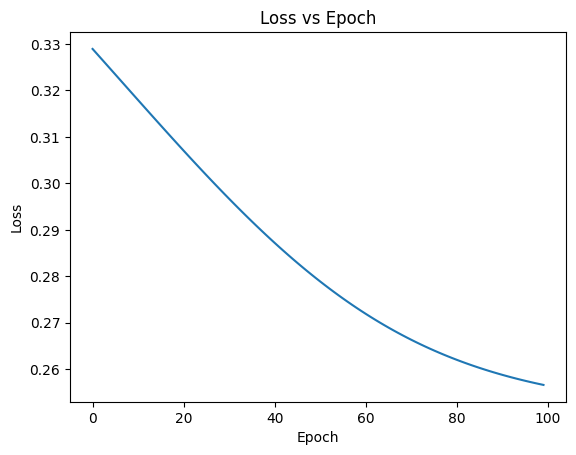

Layer 1
W = [[-0.14263201]
 [ 0.26002538]]
b = [[0.22158608]]


In [23]:
nn_xor_mse = SigmoidNN([2,1], x_2, x_2_xor_y, 0.1, 100, loss_func="mse")
nn_xor_mse.train(print_epoch=10)
nn_xor_mse.plot_loss()
nn_xor_mse.print_weights_and_biases()

Epoch 0: Loss = 0.8027358354247377, Accuracy = 0.5
Epoch 10: Loss = 0.7459313307030608, Accuracy = 0.5
Epoch 20: Loss = 0.7177764032438076, Accuracy = 0.5
Epoch 30: Loss = 0.7045552708147771, Accuracy = 0.5
Epoch 40: Loss = 0.698504335364865, Accuracy = 0.5
Epoch 50: Loss = 0.6957576611888411, Accuracy = 0.5
Epoch 60: Loss = 0.6945057346457589, Accuracy = 0.5
Epoch 70: Loss = 0.6939254310091437, Accuracy = 0.25
Epoch 80: Loss = 0.6936470158442912, Accuracy = 0.25
Epoch 90: Loss = 0.6935052316582628, Accuracy = 0.25
Epoch 100: Loss = 0.6934262719809694, Accuracy = 0.25
Epoch 110: Loss = 0.6933770904031956, Accuracy = 0.25
Epoch 120: Loss = 0.6933427900973992, Accuracy = 0.25
Epoch 130: Loss = 0.6933165620945506, Accuracy = 0.25
Epoch 140: Loss = 0.6932952114737784, Accuracy = 0.25
Epoch 150: Loss = 0.6932771679159517, Accuracy = 0.25
Epoch 160: Loss = 0.693261600094875, Accuracy = 0.5
Epoch 170: Loss = 0.6932480204673688, Accuracy = 0.5
Epoch 180: Loss = 0.6932361080079295, Accuracy = 0

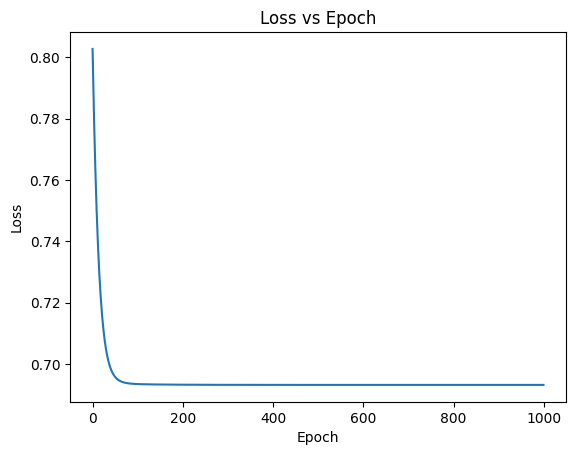

Layer 1
W = [[ 0.00010668]
 [-0.00033331]]
b = [[0.00013441]]


In [24]:
nn_xor_bce = SigmoidNN([2,1], x_2, x_2_xor_y, 0.1, 1000, loss_func="bce")
nn_xor_bce.train(print_epoch=10)
nn_xor_bce.plot_loss()
nn_xor_bce.print_weights_and_biases()

Epoch 0: Loss = 0.4797712806411243, Accuracy = 0.25
Epoch 10: Loss = 0.4238864014869037, Accuracy = 0.25
Epoch 20: Loss = 0.3637365018248342, Accuracy = 0.3125
Epoch 30: Loss = 0.3089461512471404, Accuracy = 0.375
Epoch 40: Loss = 0.26736635918840423, Accuracy = 0.5
Epoch 50: Loss = 0.23982871098911424, Accuracy = 0.5
Epoch 60: Loss = 0.22270510337475788, Accuracy = 0.625
Epoch 70: Loss = 0.21213381250840208, Accuracy = 0.6875
Epoch 80: Loss = 0.2054682893466842, Accuracy = 0.6875
Epoch 90: Loss = 0.20113102919687365, Accuracy = 0.75
Epoch 100: Loss = 0.1982127902484414, Accuracy = 0.75
Epoch 110: Loss = 0.19618501316275178, Accuracy = 0.75
Epoch 120: Loss = 0.1947328993369459, Accuracy = 0.75
Epoch 130: Loss = 0.19366349137218236, Accuracy = 0.75
Epoch 140: Loss = 0.19285507966659843, Accuracy = 0.75
Epoch 150: Loss = 0.19222881823415822, Accuracy = 0.75
Epoch 160: Loss = 0.19173237928271608, Accuracy = 0.75
Epoch 170: Loss = 0.191330275345644, Accuracy = 0.75
Epoch 180: Loss = 0.1909

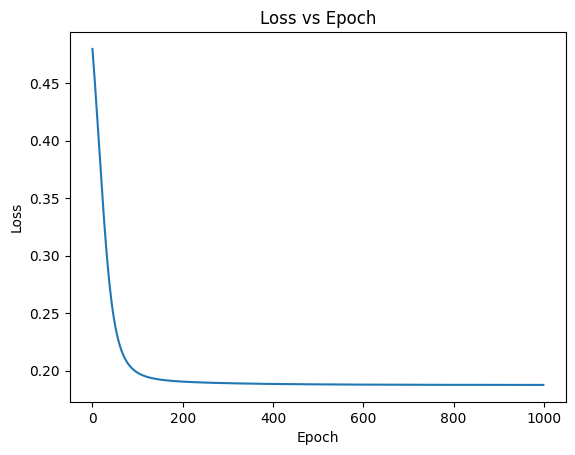

Layer 1
W = [[-0.02384259]
 [-0.09238891]
 [-0.13800172]
 [-0.06024595]]
b = [[-0.94166558]]


In [25]:
nn_pal_4_mse = SigmoidNN([4,1], x_4, x_4_palindrome_y, 0.1, 1000, loss_func="mse")
nn_pal_4_mse.train(print_epoch=10)
nn_pal_4_mse.plot_loss()
nn_pal_4_mse.print_weights_and_biases()

Epoch 0: Loss = 1.398507814159681, Accuracy = 0.25
Epoch 10: Loss = 0.8964871605815751, Accuracy = 0.25
Epoch 20: Loss = 0.6833833315745412, Accuracy = 0.5625
Epoch 30: Loss = 0.6082588280157939, Accuracy = 0.75
Epoch 40: Loss = 0.5815782055183449, Accuracy = 0.75
Epoch 50: Loss = 0.5714476690757535, Accuracy = 0.75
Epoch 60: Loss = 0.5673253213712852, Accuracy = 0.75
Epoch 70: Loss = 0.5655268434138331, Accuracy = 0.75
Epoch 80: Loss = 0.5646741449563957, Accuracy = 0.75
Epoch 90: Loss = 0.564223108096862, Accuracy = 0.75
Epoch 100: Loss = 0.5639502172219775, Accuracy = 0.75
Epoch 110: Loss = 0.5637608998301423, Accuracy = 0.75
Epoch 120: Loss = 0.5636141270887831, Accuracy = 0.75
Epoch 130: Loss = 0.5634916119883757, Accuracy = 0.75
Epoch 140: Loss = 0.5633848906518184, Accuracy = 0.75
Epoch 150: Loss = 0.5632898047727167, Accuracy = 0.75
Epoch 160: Loss = 0.5632041150288472, Accuracy = 0.75
Epoch 170: Loss = 0.5631264589997322, Accuracy = 0.75
Epoch 180: Loss = 0.5630558923159006, A

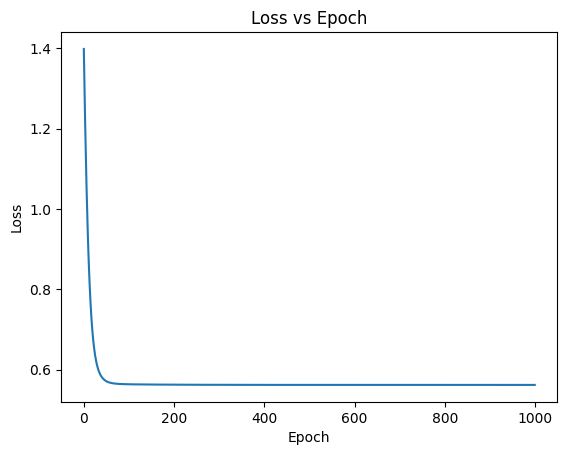

Layer 1
W = [[ 0.00104152]
 [-0.00163578]
 [ 0.00307085]
 [ 0.00271559]]
b = [[-1.10155467]]


In [26]:
nn_pal_4_bce = SigmoidNN([4,1], x_4, x_4_palindrome_y, 0.1, 1000, loss_func="bce")
nn_pal_4_bce.train(print_epoch=10)
nn_pal_4_bce.plot_loss()
nn_pal_4_bce.print_weights_and_biases()

Epoch 0: Loss = 0.5439890909197904, Accuracy = 0.25
Epoch 10: Loss = 0.49401341203703275, Accuracy = 0.25
Epoch 20: Loss = 0.4299183130486249, Accuracy = 0.25
Epoch 30: Loss = 0.3580927007492759, Accuracy = 0.28125
Epoch 40: Loss = 0.29430794950911193, Accuracy = 0.3125
Epoch 50: Loss = 0.25038089254639684, Accuracy = 0.5625
Epoch 60: Loss = 0.22471420748486648, Accuracy = 0.65625
Epoch 70: Loss = 0.21045128719989276, Accuracy = 0.78125
Epoch 80: Loss = 0.20239805926447496, Accuracy = 0.75
Epoch 90: Loss = 0.19767079541768778, Accuracy = 0.75
Epoch 100: Loss = 0.19477698031401317, Accuracy = 0.75
Epoch 110: Loss = 0.1929358416694316, Accuracy = 0.75
Epoch 120: Loss = 0.19172396630315175, Accuracy = 0.75
Epoch 130: Loss = 0.19090210098707736, Accuracy = 0.75
Epoch 140: Loss = 0.19032965485820894, Accuracy = 0.75
Epoch 150: Loss = 0.18992106680605542, Accuracy = 0.75
Epoch 160: Loss = 0.18962264835603265, Accuracy = 0.75
Epoch 170: Loss = 0.18939980809386717, Accuracy = 0.75
Epoch 180: L

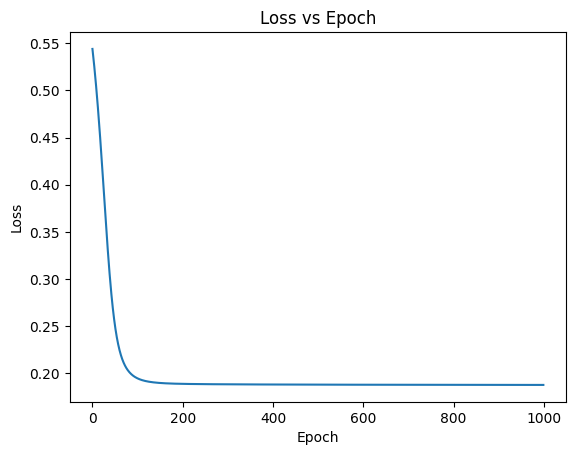

Layer 1
W = [[ 0.00960312]
 [-0.24078102]
 [-0.04179804]
 [-0.25409486]
 [-0.01677914]]
b = [[-0.84226567]]


In [27]:
nn_pal_5_mse = SigmoidNN([5,1], x_5, x_5_palindrome_y, 0.1, 1000, loss_func="mse")
nn_pal_5_mse.train(print_epoch=10)
nn_pal_5_mse.plot_loss()
nn_pal_5_mse.print_weights_and_biases()

Epoch 0: Loss = 1.688719180319577, Accuracy = 0.25
Epoch 10: Loss = 0.9952516301116436, Accuracy = 0.25
Epoch 20: Loss = 0.7120970654057622, Accuracy = 0.5
Epoch 30: Loss = 0.6226120215233562, Accuracy = 0.59375
Epoch 40: Loss = 0.593240606921261, Accuracy = 0.71875
Epoch 50: Loss = 0.5823703099330138, Accuracy = 0.75
Epoch 60: Loss = 0.5777538829836002, Accuracy = 0.75
Epoch 70: Loss = 0.5754437093540709, Accuracy = 0.75
Epoch 80: Loss = 0.5740512921247303, Accuracy = 0.75
Epoch 90: Loss = 0.5730558725184003, Accuracy = 0.75
Epoch 100: Loss = 0.5722525943943106, Accuracy = 0.75
Epoch 110: Loss = 0.5715573715154736, Accuracy = 0.75
Epoch 120: Loss = 0.5709338576918146, Accuracy = 0.75
Epoch 130: Loss = 0.570365051924942, Accuracy = 0.75
Epoch 140: Loss = 0.5698419786557679, Accuracy = 0.75
Epoch 150: Loss = 0.5693591001668572, Accuracy = 0.75
Epoch 160: Loss = 0.5689124349236353, Accuracy = 0.75
Epoch 170: Loss = 0.5684987764783078, Accuracy = 0.75
Epoch 180: Loss = 0.5681153631329849,

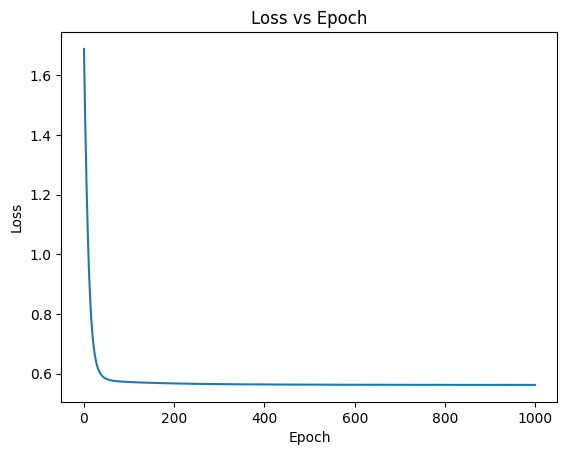

Layer 1
W = [[-0.02848493]
 [-0.0279824 ]
 [-0.03542203]
 [-0.0326378 ]
 [-0.03377708]]
b = [[-1.01056114]]


In [28]:
nn_pal_5_bce = SigmoidNN([5,1], x_5, x_5_palindrome_y, 0.1, 1000, loss_func="bce")
nn_pal_5_bce.train(print_epoch=10)
nn_pal_5_bce.plot_loss()
nn_pal_5_bce.print_weights_and_biases()

Epoch 0: Loss = 0.3925504872895574, Accuracy = 0.5
Epoch 10: Loss = 0.38266448526412566, Accuracy = 0.5
Epoch 20: Loss = 0.371569937110025, Accuracy = 0.5
Epoch 30: Loss = 0.3592548005465539, Accuracy = 0.5
Epoch 40: Loss = 0.3458313418470842, Accuracy = 0.5
Epoch 50: Loss = 0.33160275765660024, Accuracy = 0.5
Epoch 60: Loss = 0.31711202286106854, Accuracy = 0.5
Epoch 70: Loss = 0.3031191845716123, Accuracy = 0.5
Epoch 80: Loss = 0.290458247201127, Accuracy = 0.5
Epoch 90: Loss = 0.2797995899895125, Accuracy = 0.5
Epoch 100: Loss = 0.27144821382677947, Accuracy = 0.5625
Epoch 110: Loss = 0.2653094916083377, Accuracy = 0.4375
Epoch 120: Loss = 0.26101972234365783, Accuracy = 0.5
Epoch 130: Loss = 0.25812520467003064, Accuracy = 0.5
Epoch 140: Loss = 0.25620981481323857, Accuracy = 0.5
Epoch 150: Loss = 0.25494836758700956, Accuracy = 0.5
Epoch 160: Loss = 0.25410990648582543, Accuracy = 0.5
Epoch 170: Loss = 0.2535398660409133, Accuracy = 0.625
Epoch 180: Loss = 0.2531386085335293, Accu

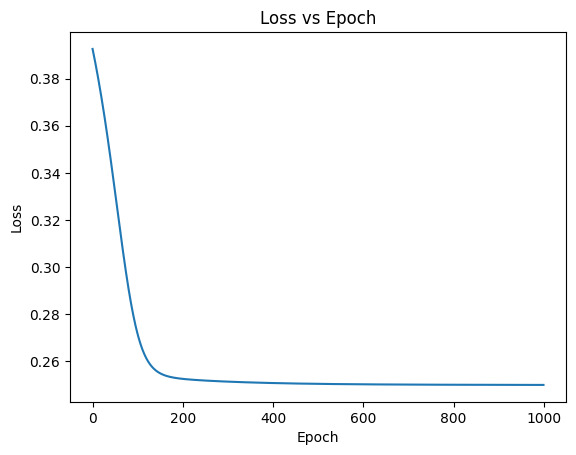

Layer 1
W = [[0.03938753]
 [0.01469502]
 [0.00562056]
 [0.04039483]]
b = [[-0.05669622]]


In [29]:
nn_even_4 = SigmoidNN([4,1], x_4, x_4_even_parity_y, 0.1, 1000, loss_func="mse")
nn_even_4.train(print_epoch=10)
nn_even_4.plot_loss()
nn_even_4.print_weights_and_biases()

Epoch 0: Loss = 0.3479899070561935, Accuracy = 0.5
Epoch 10: Loss = 0.3318972392371138, Accuracy = 0.5
Epoch 20: Loss = 0.31542360120076285, Accuracy = 0.5
Epoch 30: Loss = 0.2997086783303896, Accuracy = 0.5
Epoch 40: Loss = 0.28595917085026556, Accuracy = 0.5
Epoch 50: Loss = 0.2750025312244421, Accuracy = 0.5
Epoch 60: Loss = 0.26700995011940376, Accuracy = 0.5
Epoch 70: Loss = 0.26158984263458973, Accuracy = 0.5
Epoch 80: Loss = 0.25810140952130234, Accuracy = 0.5


Epoch 90: Loss = 0.2559244785782603, Accuracy = 0.5
Epoch 100: Loss = 0.25458054972107713, Accuracy = 0.5
Epoch 110: Loss = 0.25374402586290057, Accuracy = 0.46875
Epoch 120: Loss = 0.25320916567256146, Accuracy = 0.53125
Epoch 130: Loss = 0.25285160870145007, Accuracy = 0.46875
Epoch 140: Loss = 0.25259816587339146, Accuracy = 0.5
Epoch 150: Loss = 0.25240644041356725, Accuracy = 0.5
Epoch 160: Loss = 0.25225208688361866, Accuracy = 0.5
Epoch 170: Loss = 0.25212117431970926, Accuracy = 0.5
Epoch 180: Loss = 0.25200572062161974, Accuracy = 0.5
Epoch 190: Loss = 0.2519011206620495, Accuracy = 0.5
Epoch 200: Loss = 0.25180467936655593, Accuracy = 0.5
Epoch 210: Loss = 0.25171478042741796, Accuracy = 0.5
Epoch 220: Loss = 0.25163041732290903, Accuracy = 0.46875
Epoch 230: Loss = 0.2515509295642664, Accuracy = 0.46875
Epoch 240: Loss = 0.25147585467758604, Accuracy = 0.46875
Epoch 250: Loss = 0.25140484523512985, Accuracy = 0.46875
Epoch 260: Loss = 0.2513376223526351, Accuracy = 0.46875
E

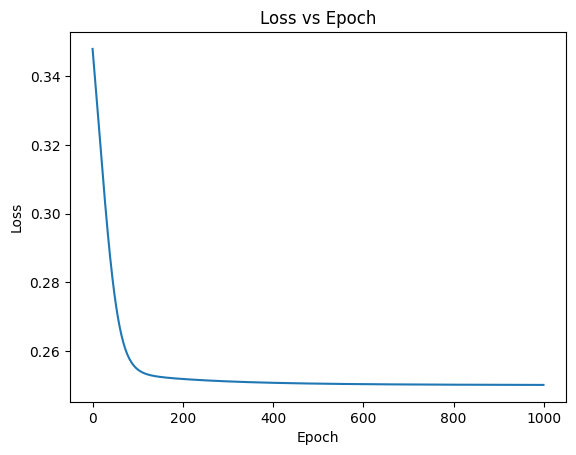

Layer 1
W = [[0.01393636]
 [0.03460393]
 [0.04305197]
 [0.01906562]
 [0.03199265]]
b = [[-0.07963726]]


In [30]:
nn_even_5 = SigmoidNN([5,1], x_5, x_5_even_parity_y, 0.1, 1000, loss_func="mse")
nn_even_5.train(print_epoch=10)
nn_even_5.plot_loss()
nn_even_5.print_weights_and_biases()

Epoch 0: Loss = 0.4374826248656015, Accuracy = 0.3125
Epoch 10: Loss = 0.39927487637062625, Accuracy = 0.3125
Epoch 20: Loss = 0.36128360108379926, Accuracy = 0.3125
Epoch 30: Loss = 0.32741917496434947, Accuracy = 0.3125
Epoch 40: Loss = 0.30010257268525053, Accuracy = 0.375
Epoch 50: Loss = 0.2794794329364384, Accuracy = 0.4375
Epoch 60: Loss = 0.26427058917818186, Accuracy = 0.5625
Epoch 70: Loss = 0.2529118325829042, Accuracy = 0.6875
Epoch 80: Loss = 0.24412600240911592, Accuracy = 0.6875
Epoch 90: Loss = 0.23702335061575605, Accuracy = 0.5625
Epoch 100: Loss = 0.231024590439536, Accuracy = 0.5625
Epoch 110: Loss = 0.22576215547627393, Accuracy = 0.5625
Epoch 120: Loss = 0.22100432871731812, Accuracy = 0.5625
Epoch 130: Loss = 0.21660483243127626, Accuracy = 0.6875
Epoch 140: Loss = 0.21247098137278586, Accuracy = 0.6875
Epoch 150: Loss = 0.20854381907228686, Accuracy = 0.75
Epoch 160: Loss = 0.20478568834605726, Accuracy = 0.6875
Epoch 170: Loss = 0.20117238582396418, Accuracy = 

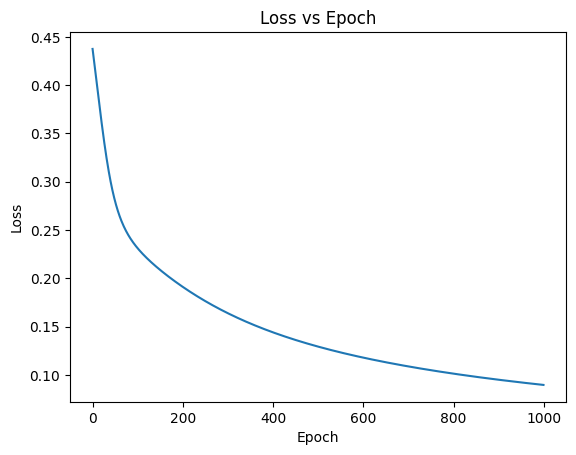

Layer 1
W = [[1.08743327]
 [1.09661819]
 [1.08724106]
 [1.12296661]]
b = [[-2.85505249]]


In [31]:
nn_majority_4_mse = SigmoidNN([4,1], x_4, x_4_majority_y, 0.1, 1000, loss_func="mse")
nn_majority_4_mse.train(print_epoch=10)
nn_majority_4_mse.plot_loss()
nn_majority_4_mse.print_weights_and_biases()

Epoch 0: Loss = 0.9450750360367821, Accuracy = 0.3125
Epoch 10: Loss = 0.7323492138494934, Accuracy = 0.5625
Epoch 20: Loss = 0.6340585899733555, Accuracy = 0.5625
Epoch 30: Loss = 0.5885507972572046, Accuracy = 0.75
Epoch 40: Loss = 0.5635779130234301, Accuracy = 0.8125
Epoch 50: Loss = 0.5464041730621829, Accuracy = 0.8125
Epoch 60: Loss = 0.5324321166867108, Accuracy = 0.8125
Epoch 70: Loss = 0.5200181260503087, Accuracy = 0.8125
Epoch 80: Loss = 0.5085555905740424, Accuracy = 0.8125
Epoch 90: Loss = 0.4978020537942016, Accuracy = 0.875
Epoch 100: Loss = 0.48764476874086576, Accuracy = 0.875
Epoch 110: Loss = 0.4780187000114078, Accuracy = 0.875
Epoch 120: Loss = 0.4688776477566572, Accuracy = 0.875
Epoch 130: Loss = 0.460183959709494, Accuracy = 0.875
Epoch 140: Loss = 0.45190476875665636, Accuracy = 0.875
Epoch 150: Loss = 0.44401052837873217, Accuracy = 0.875
Epoch 160: Loss = 0.4364743622035359, Accuracy = 0.875
Epoch 170: Loss = 0.4292717072086536, Accuracy = 0.875
Epoch 180: L

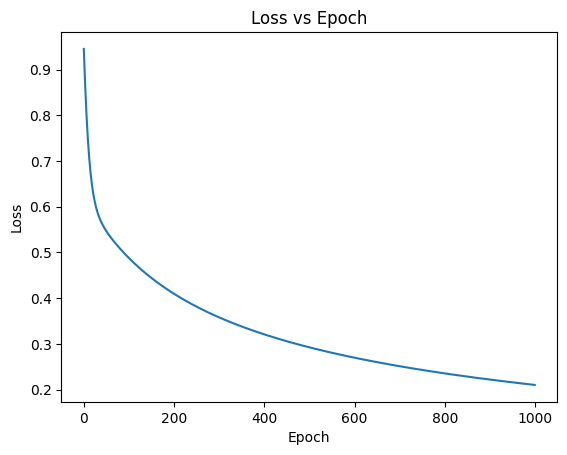

Layer 1
W = [[1.97224711]
 [1.97325846]
 [1.96513638]
 [1.96751684]]
b = [[-5.05447953]]


In [32]:
nn_majority_4_bce = SigmoidNN([4,1], x_4, x_4_majority_y, 0.1, 1000, loss_func="bce")
nn_majority_4_bce.train(print_epoch=10)
nn_majority_4_bce.plot_loss()
nn_majority_4_bce.print_weights_and_biases()

Epoch 0: Loss = 0.33782329186187415, Accuracy = 0.5
Epoch 10: Loss = 0.32032131167045413, Accuracy = 0.5
Epoch 20: Loss = 0.3014323143696147, Accuracy = 0.5
Epoch 30: Loss = 0.28184309653013745, Accuracy = 0.5
Epoch 40: Loss = 0.26255866539195993, Accuracy = 0.5
Epoch 50: Loss = 0.24471105336953078, Accuracy = 0.5625
Epoch 60: Loss = 0.2292355628335231, Accuracy = 0.5625
Epoch 70: Loss = 0.21659030995183415, Accuracy = 0.5625
Epoch 80: Loss = 0.206697871569657, Accuracy = 0.59375
Epoch 90: Loss = 0.19911221806133597, Accuracy = 0.625
Epoch 100: Loss = 0.19325914450126674, Accuracy = 0.65625
Epoch 110: Loss = 0.18861180128179067, Accuracy = 0.71875
Epoch 120: Loss = 0.1847649149954056, Accuracy = 0.78125
Epoch 130: Loss = 0.1814386801356395, Accuracy = 0.8125
Epoch 140: Loss = 0.17845289842879464, Accuracy = 0.8125
Epoch 150: Loss = 0.17569659557934314, Accuracy = 0.8125
Epoch 160: Loss = 0.1731032436611152, Accuracy = 0.8125
Epoch 170: Loss = 0.17063344205105696, Accuracy = 0.8125
Epoc

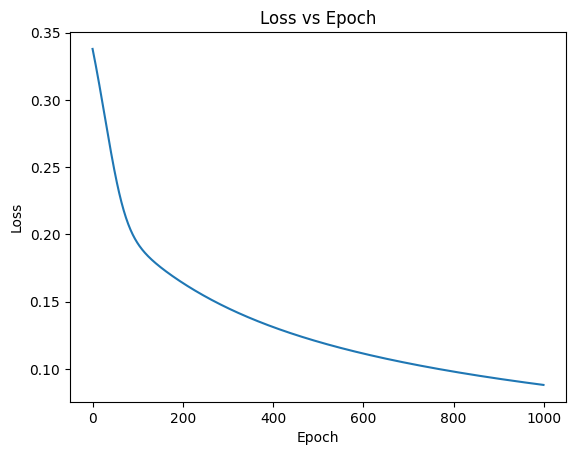

Layer 1
W = [[1.1775241 ]
 [1.18207919]
 [1.14505092]
 [1.18423565]
 [1.1688622 ]]
b = [[-2.78994416]]


In [33]:
nn_majority_5_mse = SigmoidNN([5,1], x_5, x_5_majority_y, 0.1, 1000, loss_func="mse")
nn_majority_5_mse.train(print_epoch=10)
nn_majority_5_mse.plot_loss()
nn_majority_5_mse.print_weights_and_biases()

Epoch 0: Loss = 0.7866093987043008, Accuracy = 0.5
Epoch 10: Loss = 0.6602589409858728, Accuracy = 0.53125
Epoch 20: Loss = 0.5902809050481712, Accuracy = 0.5625
Epoch 30: Loss = 0.5535915715230614, Accuracy = 0.625
Epoch 40: Loss = 0.5327989847381939, Accuracy = 0.71875
Epoch 50: Loss = 0.5187760543306887, Accuracy = 0.75
Epoch 60: Loss = 0.5075929454101789, Accuracy = 0.75
Epoch 70: Loss = 0.4977171413117175, Accuracy = 0.78125
Epoch 80: Loss = 0.4885713318285367, Accuracy = 0.8125
Epoch 90: Loss = 0.47993310563238, Accuracy = 0.84375
Epoch 100: Loss = 0.47170818470146186, Accuracy = 0.84375
Epoch 110: Loss = 0.46384859220030905, Accuracy = 0.84375
Epoch 120: Loss = 0.45632368913043686, Accuracy = 0.84375
Epoch 130: Loss = 0.4491099511874457, Accuracy = 0.875
Epoch 140: Loss = 0.4421873116931002, Accuracy = 0.90625
Epoch 150: Loss = 0.4355378018639407, Accuracy = 0.90625
Epoch 160: Loss = 0.4291450003141948, Accuracy = 0.9375
Epoch 170: Loss = 0.4229937725786911, Accuracy = 0.96875
E

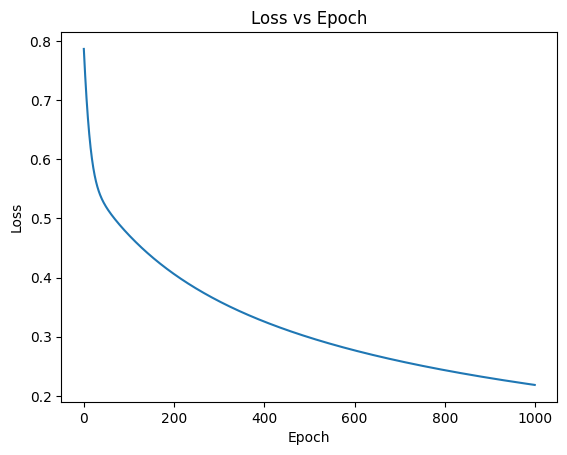

Layer 1
W = [[1.95878677]
 [1.95620251]
 [1.95787808]
 [1.95371151]
 [1.95587382]]
b = [[-4.71289863]]


In [34]:
nn_majority_5_bce = SigmoidNN([5,1], x_5, x_5_majority_y, 0.1, 1000, loss_func="bce")
nn_majority_5_bce.train(print_epoch=10)
nn_majority_5_bce.plot_loss()
nn_majority_5_bce.print_weights_and_biases()